In [1]:
import os

print(os.environ['SPARK_HOME'])

/usr/share/spark


# Build a predictive model capable of predicting the total number of bike rentals per hour for agiven weekday. 
Note: you may also want to add weather information to improve model
accuracy, i.e , be able to predict nb of bike rentals per hour for weekday and weather
conditions , or even add more features ( like e.g. : bank holidays information )

In [2]:
import findspark
findspark.init()
import pyspark
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from datetime import datetime
from pyspark.sql.functions import col, udf,to_date,unix_timestamp,from_unixtime
from pyspark.sql.types import DateType
from pyspark.sql.functions import date_format
from pyspark.sql.functions import year, month, dayofmonth, hour

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .master("spark://data1p:7077") \
    .appName("Final-Assignment-Group3-BikeRental") \
    .getOrCreate()

In [4]:
dataset_path="/data/shared/spark/challenge_3/"

In [5]:
# Read in all available data files into a data frame
df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv("file://"+dataset_path+"20*.csv")    

In [6]:
df.printSchema()

root
 |-- Duration (ms): integer (nullable = true)
 |-- Start date: timestamp (nullable = true)
 |-- End date: timestamp (nullable = true)
 |-- Start station number: string (nullable = true)
 |-- Start station: string (nullable = true)
 |-- End station number: string (nullable = true)
 |-- End station: string (nullable = true)
 |-- Bike number: string (nullable = true)
 |-- Member type: string (nullable = true)



In [7]:
df.count()

19120900

Seperate Date and time from Start Date

In [8]:
import pyspark.sql.functions as F
split_col = pyspark.sql.functions.split(df['Start date'], ' ')
df = df.withColumn('Date', split_col.getItem(0))

In [9]:
split_col = pyspark.sql.functions.split(df['Start date'], ' ')
df = df.withColumn('Time', split_col.getItem(1))

In [10]:
df.printSchema()

root
 |-- Duration (ms): integer (nullable = true)
 |-- Start date: timestamp (nullable = true)
 |-- End date: timestamp (nullable = true)
 |-- Start station number: string (nullable = true)
 |-- Start station: string (nullable = true)
 |-- End station number: string (nullable = true)
 |-- End station: string (nullable = true)
 |-- Bike number: string (nullable = true)
 |-- Member type: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Time: string (nullable = true)



In [11]:
df=df.withColumn("Date",col("Date").cast("date"))
df=df.withColumn("Time",col("Time").cast("timestamp"))
df.printSchema()

root
 |-- Duration (ms): integer (nullable = true)
 |-- Start date: timestamp (nullable = true)
 |-- End date: timestamp (nullable = true)
 |-- Start station number: string (nullable = true)
 |-- Start station: string (nullable = true)
 |-- End station number: string (nullable = true)
 |-- End station: string (nullable = true)
 |-- Bike number: string (nullable = true)
 |-- Member type: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- Time: timestamp (nullable = true)



In [12]:
df = df.select('Date','Time','Duration (ms)','Start station','End station','Member type')

In [13]:
df.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Time: timestamp (nullable = true)
 |-- Duration (ms): integer (nullable = true)
 |-- Start station: string (nullable = true)
 |-- End station: string (nullable = true)
 |-- Member type: string (nullable = true)



# Import Weather Data

In [14]:
df2 = spark.read \
    .option("inferSchema", "true") \
    .csv("file://"+dataset_path+"weather_data_daily.csv")
    
features=[ "Site4","Date","Source", 
            "Max Temp","Avg Temp","HDDs", \
            "CDDs","Precipitation", \
            "Snowfall","Snow/Ice"]
#target=["median_value"]

fieldnames=features #+target

rawnames=df2.schema.names

# Create a small function
def updateColNames(df,oldnames,newnames):
    for i in range(len(newnames)):
        df=df.withColumnRenamed(oldnames[i], newnames[i])
    return df

df2=updateColNames(df2,rawnames,fieldnames)

df2.printSchema()

root
 |-- Site4: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Max Temp: integer (nullable = true)
 |-- Avg Temp: integer (nullable = true)
 |-- HDDs: double (nullable = true)
 |-- CDDs: double (nullable = true)
 |-- Precipitation: double (nullable = true)
 |-- Snowfall: double (nullable = true)
 |-- Snow/Ice: double (nullable = true)
 |-- _c10: double (nullable = true)



In [15]:
split_col = pyspark.sql.functions.split(df2['Date'], ' ')
df2 = df2.withColumn('Date', split_col.getItem(0))

In [16]:
df2.show()

+-----+---------+------+--------+--------+----+----+-------------+--------+--------+----+
|Site4|     Date|Source|Max Temp|Avg Temp|HDDs|CDDs|Precipitation|Snowfall|Snow/Ice|_c10|
+-----+---------+------+--------+--------+----+----+-------------+--------+--------+----+
| KIAD| 1/1/2010|  NCDC|      43|      28|35.5|29.5|          0.0|     0.0|     0.0| 0.0|
| KIAD| 1/2/2010|  NCDC|      28|      18|23.0|42.0|          0.0|     0.0|     0.0| 0.0|
| KIAD| 1/3/2010|  NCDC|      26|      14|20.0|45.0|          0.0|     0.0|     0.0| 0.0|
| KIAD| 1/4/2010|  NCDC|      32|      21|26.5|38.5|          0.0|     0.0|     0.0| 0.0|
| KIAD| 1/5/2010|  NCDC|      35|      27|31.0|34.0|          0.0|     0.0|     0.0| 0.0|
| KIAD| 1/6/2010|  NCDC|      37|      28|32.5|32.5|          0.0|  1.0E-4|   0.001| 0.0|
| KIAD| 1/7/2010|  NCDC|      37|      28|32.5|32.5|          0.0|    0.01|     0.2| 0.0|
| KIAD| 1/8/2010|  NCDC|      32|      22|27.0|38.0|          0.0|    0.05|     1.0| 1.0|
| KIAD| 1/

# Merge both Data Sets by date

In [17]:
df2 = df2.select('Date','Avg Temp','Precipitation', from_unixtime(unix_timestamp('Date', 'MM/dd/yyy')).alias('date2'))


In [18]:
split_col = pyspark.sql.functions.split(df2['date2'], ' ')
df2 = df2.withColumn('date2', split_col.getItem(0))
df2 = df2.select('date2','Avg Temp','Precipitation')
df2.show()

+----------+--------+-------------+
|     date2|Avg Temp|Precipitation|
+----------+--------+-------------+
|2010-01-01|      28|          0.0|
|2010-01-02|      18|          0.0|
|2010-01-03|      14|          0.0|
|2010-01-04|      21|          0.0|
|2010-01-05|      27|          0.0|
|2010-01-06|      28|          0.0|
|2010-01-07|      28|          0.0|
|2010-01-08|      22|          0.0|
|2010-01-09|      22|          0.0|
|2010-01-10|      19|          0.0|
|2010-01-11|      13|          0.0|
|2010-01-12|      27|          0.0|
|2010-01-13|      23|          0.0|
|2010-01-14|      19|          0.0|
|2010-01-15|      21|          0.0|
|2010-01-16|      27|          0.0|
|2010-01-17|      35|          0.0|
|2010-01-18|      31|          0.0|
|2010-01-19|      28|          0.0|
|2010-01-20|      34|          0.0|
+----------+--------+-------------+
only showing top 20 rows



In [19]:
Trips_Weather = df.join(df2, df.Date == df2.date2)
Trips_Weather.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Time: timestamp (nullable = true)
 |-- Duration (ms): integer (nullable = true)
 |-- Start station: string (nullable = true)
 |-- End station: string (nullable = true)
 |-- Member type: string (nullable = true)
 |-- date2: string (nullable = true)
 |-- Avg Temp: integer (nullable = true)
 |-- Precipitation: double (nullable = true)



In [20]:
Trips_Weather.select('Date','Time','Duration (ms)','Start station','End station','Member type','Avg Temp','Precipitation')
Trips_Weather.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Time: timestamp (nullable = true)
 |-- Duration (ms): integer (nullable = true)
 |-- Start station: string (nullable = true)
 |-- End station: string (nullable = true)
 |-- Member type: string (nullable = true)
 |-- date2: string (nullable = true)
 |-- Avg Temp: integer (nullable = true)
 |-- Precipitation: double (nullable = true)



Monday:1 to sunday:7

In [21]:
Trips_ML=Trips_Weather.select(date_format('Date', 'u').alias('dow_number'),year("Date").alias('year'),month("Date").alias('month')
                         , dayofmonth("Date").alias('day'),hour("Time").alias('hour'),'Duration (ms)'
                         ,'Start station','End Station','Member type','Avg Temp','Precipitation')


# Transform to Pandas for data inspections

In [22]:
pd_df=Trips_ML.filter(Trips_ML['year']==2017).toPandas()

Load Station Data from XML file

In [23]:
import pandas as pd
import xml.etree.cElementTree as et
parsedXML = et.parse( "stations_data.xml" )
dfcols = ['name', 'lat', 'long']
df_xml = pd.DataFrame(columns=dfcols)

In [24]:
root = parsedXML.getroot()

In [25]:
for i in range(len(root.getchildren())):
    obj = root.getchildren()[i].getchildren()
    row = dict(zip(['name', 'lat', 'long'], [obj[1].text, obj[4].text, obj[5].text]))
    row_s = pd.Series(row)
    row_s.name = i
    df_xml= df_xml.append(row_s)

In [26]:
df_xml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 490 entries, 0 to 489
Data columns (total 3 columns):
name    490 non-null object
lat     490 non-null object
long    490 non-null object
dtypes: object(3)
memory usage: 15.3+ KB


In [27]:
stations=pd_df.merge(df_xml, left_on='Start station', right_on='name', how='inner')

In [28]:
stations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3758151 entries, 0 to 3758150
Data columns (total 14 columns):
dow_number       object
year             int64
month            int64
day              int64
hour             int64
Duration (ms)    int64
Start station    object
End Station      object
Member type      object
Avg Temp         int64
Precipitation    float64
name             object
lat              object
long             object
dtypes: float64(1), int64(6), object(7)
memory usage: 430.1+ MB


In [29]:
stations=stations.rename(columns = {'Start station':'station'})

In [30]:
sttaions_count=stations.groupby(['station','lat','long'], as_index=False).agg({'day':'count'})

Number of rides per member Type

In [31]:
bike_trips=pd_df

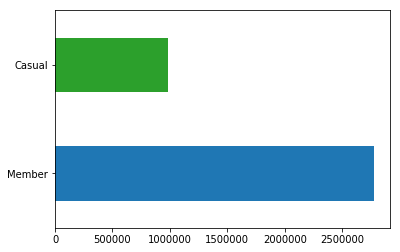

In [32]:
palette=[sns.color_palette()[0],sns.color_palette()[2],sns.color_palette()[1]]
bike_trips['Member type'].value_counts().plot(kind='barh', color=palette)

Number of Rides per month

/usr/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


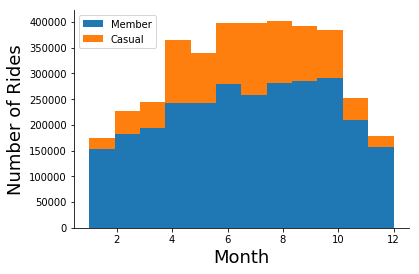

In [33]:
hist1=bike_trips[bike_trips['Member type'] == 'Member'].month
hist2=bike_trips[bike_trips['Member type'] == 'Casual'].month


n,b,p=plt.hist([hist1, hist2], stacked=True,range=[1,12], bins=12)
plt.legend(['Member','Casual'],loc=0)

plt.xlabel('Month', fontsize=18)
plt.ylabel('Number of Rides', fontsize=18)
sns.despine()

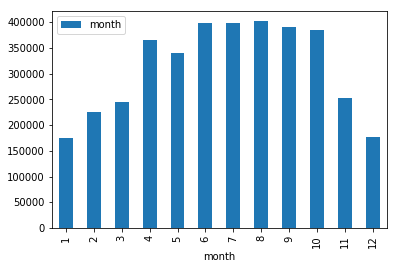

In [34]:
bike_trips[['month']].groupby(bike_trips.month).count().plot(kind="bar")

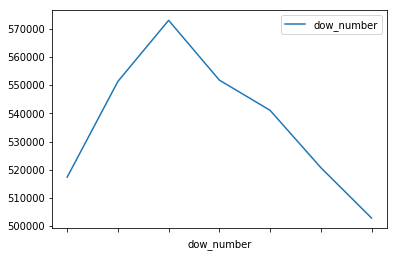

In [35]:
days = {1:'Mon',2:'Tues',3:'Weds',4:'Thurs',5:'Fri',6:'Sat',7:'Sun'}
bike_trips[['dow_number']].groupby(bike_trips.dow_number).count().plot(kind="line")


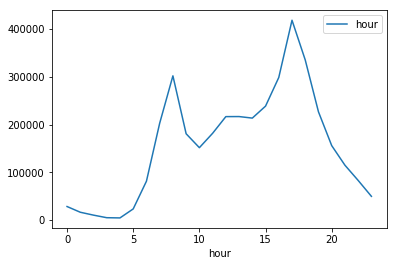

In [36]:
bike_trips[['hour']].groupby(bike_trips.hour).count().plot(kind="line")

Stations Map

# Transform Dataset for Modeling

In [37]:
Trips_ML.printSchema()

root
 |-- dow_number: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- Duration (ms): integer (nullable = true)
 |-- Start station: string (nullable = true)
 |-- End Station: string (nullable = true)
 |-- Member type: string (nullable = true)
 |-- Avg Temp: integer (nullable = true)
 |-- Precipitation: double (nullable = true)



# Create a dummy variable for weekdays

In [38]:
Trips_ML = Trips_ML.select('Start station','year','month','day','hour','Avg Temp','Precipitation', Trips_ML.dow_number.cast('integer').alias('dow'))

In [39]:
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf
def func(dow):
    if dow <6:
        return 1
    else:
        return 0

func_udf = udf(func, IntegerType())

In [40]:
Trips_ML = Trips_ML.withColumn('dummy',func_udf(Trips_ML['dow']))

In [41]:
Trips_ML.printSchema()

root
 |-- Start station: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- Avg Temp: integer (nullable = true)
 |-- Precipitation: double (nullable = true)
 |-- dow: integer (nullable = true)
 |-- dummy: integer (nullable = true)



Add Public Holiday to the dummies

In [42]:
Fixed_Holidays=[[1,1],[4,7],[11,11],[25,12]]

In [43]:
def func(dummy,month, day):
    for i in range(len(Fixed_Holidays)):
        if day==Fixed_Holidays[i][0] & month==Fixed_Holidays[i][1] & dummy==1:
            return 0
        else:
            return dummy

func_fixed = udf(func, IntegerType())

In [44]:
Trips_ML = Trips_ML.withColumn('dummy',func_fixed(Trips_ML['dummy'],Trips_ML['month'],Trips_ML['day']))

[Day,FirstIndex,LastIndex,Month]


In [45]:
Floating_Holidays=[[1,15,21,1],[1,15,21,2],[1,25,31,5],[1,1,7,9],[1,8,14,10],[5,22,28,11]]

In [46]:
def func(dow,dummy,month, day):
    for i in range(len(Floating_Holidays)):
        if dow==Floating_Holidays[i][0] & day >= Floating_Holidays[i][1] & day <= Floating_Holidays[i][2] & month==Floating_Holidays[i][3] & dummy==1:
            return 0
        else:
            return dummy

func_floating = udf(func, IntegerType())

In [47]:
Trips_ML = Trips_ML.withColumn('dummy',func_floating(Trips_ML['dow'],Trips_ML['dummy'],Trips_ML['month'],Trips_ML['day']))

In [48]:
Trips_ML.printSchema()

root
 |-- Start station: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- Avg Temp: integer (nullable = true)
 |-- Precipitation: double (nullable = true)
 |-- dow: integer (nullable = true)
 |-- dummy: integer (nullable = true)



Create final dataframe for Modeling

In [49]:
Trips_ML=Trips_ML.select(col("Start station").alias("station"),col("dummy").alias("Weekday"),col("Avg Temp").alias("Avg_Temp"),col("Precipitation"),col("hour"))

In [50]:
Final_data=Trips_ML.groupby([Trips_ML.Weekday,Trips_ML.Avg_Temp,Trips_ML.Precipitation,Trips_ML.hour]).count()

In [51]:
Final_data.show()

+-------+--------+-------------+----+-----+
|Weekday|Avg_Temp|Precipitation|hour|count|
+-------+--------+-------------+----+-----+
|      0|      63|         10.0|  16| 2846|
|      0|      58|          4.0|   2|  102|
|      1|      54|          0.0|  10| 4665|
|      1|      71|         17.0|  11| 1104|
|      0|      38|          0.0|  15| 9494|
|      1|      46|          0.0|   7|13984|
|      1|      64|          6.0|   2|   16|
|      0|      64|          2.5|   7|  126|
|      1|      63|          8.5|   7|  810|
|      0|      52|          1.5|   5|   23|
|      1|      65|          8.5|   0|  128|
|      1|      69|         13.5|  11| 1736|
|      1|      51|          0.0|   7| 9911|
|      1|      57|          0.0|   2|  172|
|      1|      61|          5.0|   5|  156|
|      0|      59|          1.5|  16|  635|
|      0|      63|          6.5|  19| 2043|
|      1|      65|          4.5|  11|  289|
|      1|      57|          5.0|   1|   93|
|      1|      57|          5.0|